In [135]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer


from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [101]:
def f_describe(data, column, feature):
    
    """
    f_describe - describe depending on the feature
    
    """
    
    described_data = pd.DataFrame(index = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'])
    described = data[[column]].describe()
    
    new_name = "{}".format(column)
    described.rename(columns = {column: new_name}, inplace = True)
    
    if data[feature].nunique() == 1:
        return described
    
    else:
        described_data = pd.concat([described_data, described], axis=1)
        
        
        values = data[feature].unique()
        
        for index, value in enumerate(values):
            new_name = "{}: {}".format(feature, value)
            described = data[data[feature] == value][[column]].describe()
            described.rename(columns = {column: new_name}, inplace = True)
            
            described_data = pd.concat([described_data, described], axis=1)
            
        return described_data

In [102]:
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold = 0.8):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

In [131]:
def function(y_true, y_pred, discount = 0.2):
    
    matrix = confusion_matrix(y_true, y_pred)
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    return 1 - (FN + discount*FP)/(TN + discount*TP)

### loading, getting dummies and cleaning data

In [103]:
raw_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [104]:
data = pd.get_dummies(raw_data, columns=["Churn"], drop_first=True)

In [105]:
data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

### splitting dataset into train and test sets

In [106]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

### pipeline, best random forest classifier and feature importances

In [107]:
data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])

In [108]:
num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

data_prepared = full_pipeline.fit_transform(data)

In [8]:
params_grid = {
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 3, 5],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf": [1, 3, 5], 
    "max_features": [None, "sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

gridsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=44),
                          param_grid = params_grid,
                          scoring = "f1",
                          n_jobs = -1,
                          cv = 5
                         )

gridsearch.fit(data_prepared, data_labels)

C:\Users\nemet\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=44), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='f1')

In [8]:
#gridsearch.best_estimator_
best_rf = RandomForestClassifier(class_weight='balanced',
                                 criterion='entropy',
                                 max_features='log2',
                                 min_samples_leaf=5,
                                 random_state=44)

best_rf.fit(data_prepared, data_labels);

### 10 most important features

In [21]:
transformed_cat_attribs = full_pipeline.named_transformers_["cat"].get_feature_names()
feature_names = np.concatenate((num_attribs, transformed_cat_attribs))

feature_importance_data = pd.DataFrame({"Feature_name": feature_names, "feature_importance": best_rf.feature_importances_})
feature_importance_data = feature_importance_data.sort_values(by="feature_importance", ascending=False)

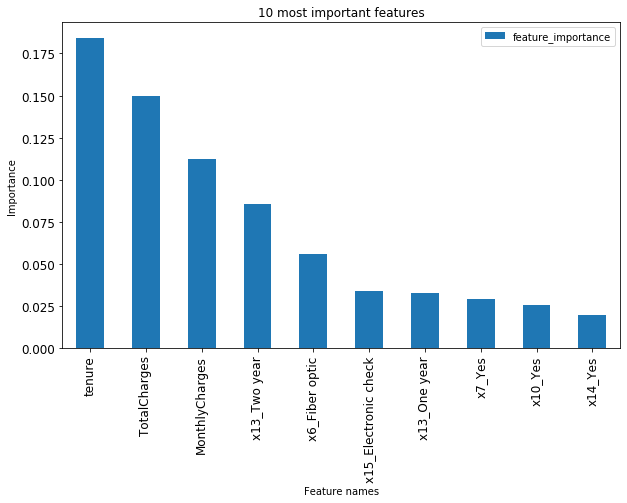

In [53]:
feature_importance_data.iloc[:10,:].plot(x = "Feature_name",
                                         kind = "bar",
                                         figsize = (10, 6),
                                         fontsize = 12,
                                         title = "10 most important features",
                                         xlabel = "Feature names",
                                         ylabel = "Importance");

### MonthlyCharges

In [72]:
pd.options.display.float_format = '{:.2f}'.format
f_desc = f_describe(raw_data, "MonthlyCharges", "Churn")
f_desc

,MonthlyCharges,Churn: No,Churn: Yes
count,7043.00,5174.00,1869.00
mean,64.76,61.27,74.44
std,30.09,31.09,24.67
min,18.25,18.25,18.85
25%,35.50,25.10,56.15
50%,70.35,64.43,79.65
75%,89.85,88.40,94.20
max,118.75,118.75,118.35


In [93]:
mean_diff = round((f_desc.iloc[1,:][2] / f_desc.iloc[1,:][1] * 100) - 100, 2)
median_diff = round((f_desc.iloc[5,:][2] / f_desc.iloc[5,:][1] * 100) - 100, 2)

print("Monthly charges")
print("differences in means: {}%\ndifferences in medians: {}%".format(mean_diff, median_diff))

differences in means: 21.51%
differences in medians: 23.63%


### pipeline, splitting prepared data into train and validation sets

In [109]:
full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=5,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

In [110]:
pipeline = Pipeline([("droper", DropTransformer(threshold = 0.9))])

data_prepared = pipeline.fit_transform(new_data)

It works!


In [111]:
X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25,
                                                  random_state=44, stratify=data_labels)

### metric selection

In [114]:
sample_model = KNeighborsClassifier()

sample_model.fit(X_train, y_train);

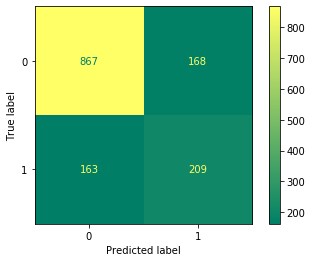

In [127]:
plot_confusion_matrix(sample_model, X_val, y_val, cmap="summer");

### Slytherin score

$$ score = \frac{TN - FN + d\cdot TP - d\cdot FP}{TN + d\cdot TP} = 1 - \frac{FN + d\cdot FP}{TN + d\cdot TP}$$


$d$ - discount

In [136]:
slytherin_score = make_scorer(function)

### F1 vs slytherin

In [137]:
params_grid = {
    "C": [0.1, 0.2, 0.5, 1],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [1, 2, 3],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}

gridsearch_f1 = GridSearchCV(estimator = SVC(random_state=44),
                             param_grid = params_grid,
                             scoring = "f1",
                             n_jobs = -1,
                             verbose = 1,
                             cv = 5
                            )

gridsearch_f1.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='f1', verbose=1)

In [138]:
params_grid = {
    "C": [0.1, 0.2, 0.5, 1],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [1, 2, 3],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}

gridsearch_ss = GridSearchCV(estimator = SVC(random_state=44),
                             param_grid = params_grid,
                             scoring = slytherin_score,
                             n_jobs = -1,
                             verbose = 1,
                             cv = 5
                            )

gridsearch_ss.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1],
                         'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring=make_scorer(function), verbose=1)

In [139]:
f1_results = pd.DataFrame(gridsearch_f1.cv_results_)[["params", "mean_test_score", "std_test_score"]]
f1_results = f1_results.rename(columns={"params": "params_f1",
                                        "mean_test_score": "mean_test_score_f1",
                                        "std_test_score": "std_test_score_f1"
                                       })


ss_results = pd.DataFrame(gridsearch_ss.cv_results_)[["params", "mean_test_score", "std_test_score"]]
ss_results = ss_results.rename(columns={"params": "params_ss",
                                        "mean_test_score": "mean_test_score_ss",
                                        "std_test_score": "std_test_score_ss"
                                       })

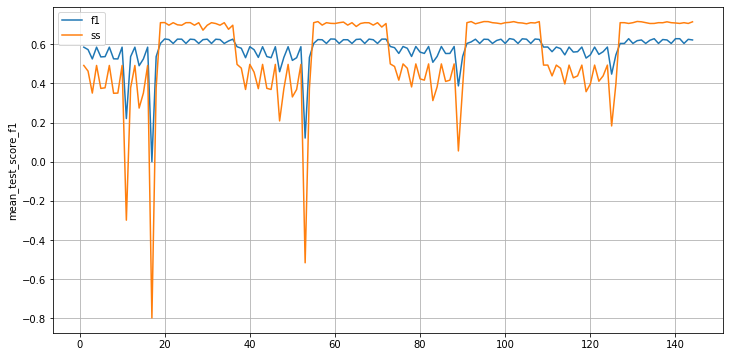

In [146]:
comparison = pd.concat([f1_results, ss_results], axis=1)

X = range(1, len(comparison)+1)
y_f1 = comparison["mean_test_score_f1"]
y_ss = comparison["mean_test_score_ss"]

fig = plt.figure(figsize=(12,6))
sns.lineplot(x = X, y = y_f1, label = "f1")
sns.lineplot(x = X, y = y_ss, label = "ss")
plt.grid()